In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sea
import random
import scipy.stats as stats
#!pip install xgboost
from collections import defaultdict
from scipy import stats
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import tree
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn import metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, explained_variance_score, r2_score, classification_report
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
#from xgboost import XGBRegressor
#from lightgbm import LGBMRegressor
import warnings; warnings.simplefilter('ignore')

data = pd.read_csv('movies_metadata.csv')
data.drop(['belongs_to_collection', 'homepage', 'original_title', 'overview','production_companies' , 'tagline', 'status', 'video', 'id', 'imdb_id'],axis=1,inplace=True)
data.dropna(inplace=True)
data['budget'] = data['budget'].astype(np.float)
data['popularity'] = data['popularity'].astype(np.float)
data = data[~(data == 0).any(axis=1)]
data['revenueinlog'] = np.log1p(data['revenue'])
data['revenuemillions'] = data['revenue']/1000000

data['genres'] = data['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
#data['production_companies'] = data['production_companies'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
data['production_countries'] = data['production_countries'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
data['spoken_languages'] = data['spoken_languages'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

data['poster_path'].fillna(0, inplace=True)
data.loc[data['poster_path'] != 0, 'poster_path'] = 1

In [2]:
data['release_date'] = pd.to_datetime(data['release_date'], infer_datetime_format=True)
data['day'] = data['release_date'].apply(lambda t: t.day)
data['weekday'] = data['release_date'].apply(lambda t: t.weekday())
data['month'] = data['release_date'].apply(lambda t: t.month)
data['year'] = data['release_date'].apply(lambda t: t.year if t.year < 2018 else t.year -100)
# Year was being interpreted as future dates in some cases so I had to adjust some values


In [3]:
#data[['release_date','day','week','month','year']].head()
#sea.countplot(x='day',data=data)
#sea.countplot(x='weekday',data=data)
#sea.countplot(x='month',data=data)
#plt.figure(figsize=(25,15))
#sea.countplot(x='year',data=data)
#plt.xticks(rotation=90)

X = data[data['budget'] != 0]
for i in X.select_dtypes(include='number', exclude='datetime'):
    print(i, stats.pearsonr(X.budget, X[i]))

budget (1.0, 0.0)
popularity (0.3071516772660544, 1.633594934752139e-117)
poster_path (nan, 1.0)
revenue (0.7299914747137763, 0.0)
runtime (0.19108877683786404, 2.8745731959592137e-45)
vote_average (-0.013256789119359867, 0.33177057205340066)
vote_count (0.5860845154191411, 0.0)
revenueinlog (0.5092390508941195, 0.0)
revenuemillions (0.7299914747137763, 0.0)
day (0.032231196436209766, 0.01826438864150039)
weekday (-0.13462961495943623, 4.1150890487167184e-23)
month (0.02503400973423872, 0.06680373071447869)
year (0.26580236416433906, 2.1435284304329103e-87)


In [4]:
# vote count and popularity correlate most strongly with budget
def map_budget(df):
    d = defaultdict()
    #df['budget'] = df['budget'].fillna(0)
    X = data[data['budget'] != 0]
    
    vote_count_mean = pd.Series(X.groupby(['vote_count'])['budget'].agg('mean'))
    d = dict(vote_count_mean)
    
    for i in data[data['budget'] == 0]:
        data['budget'] = data.loc[:, 'vote_count'].map(d)
    
    return data



In [5]:
data = map_budget(data)
data.budget.describe()

count    5.362000e+03
mean     3.118646e+07
std      3.605405e+07
min      1.000000e+00
25%      1.113333e+07
50%      1.975000e+07
75%      3.500000e+07
max      3.800000e+08
Name: budget, dtype: float64

In [6]:
genres= data.genres.str.get_dummies(sep=',')
data =pd.concat([data,genres],axis=1)
data.drop(['genres'],axis=1,inplace=True)
#data.head()

In [7]:
company = data.production_countries.str.get_dummies(sep=',')

data =pd.concat([data,company],axis=1)
data.drop(['production_countries'],axis=1,inplace=True)
#data.head()

In [8]:
language = pd.get_dummies(data['original_language'])

data = pd.concat([data, language], axis=1)      
data.drop(['original_language'], inplace=True, axis=1)

In [9]:
data.drop(['adult', 'release_date', 'spoken_languages', 'title'],axis=1,inplace=True)

In [11]:
database = data.drop(['revenue'],axis=1)
target = data['revenue']

train_data, test_data, train_target, test_target = train_test_split(database, target, test_size = 0.3, random_state = 0) 
#print("Shape of X_train is : ",database_train.shape[0])
#print("Shape of y_train is : ",target_train.shape[0])
#print("Shape of X_test is : ",database_test.shape[0])
#print("Shape of y_test is : ",target_test.shape[0])

In [12]:
LinearReg = LinearRegression()
LinearReg.fit(train_data,train_target)
Prediction = LinearReg.predict(test_data)

#database_train.head()

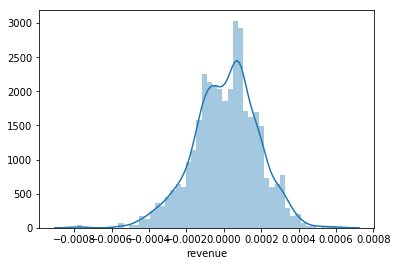

In [13]:
sea.distplot((test_target-Prediction),bins=50)
plt.show()
#target_test.head()